In [11]:
import torch
import torch.nn as nn
import torchvision
from gan import *
from torchinfo import summary
from torchvision import transforms
import os

In [12]:
BATCHSIZE=100
LATENTSIZE=64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
mnist = torchvision.datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(mnist, batch_size=BATCHSIZE, shuffle=True, drop_last=True)

In [13]:
G = Generator([LATENTSIZE, 256, 28*28]).cuda()
D = Discriminator([28*28, 256, 1]).cuda()

In [14]:
criterion = nn.BCELoss()
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)

In [15]:
def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

In [16]:
EPOCHS = 10
for epoch in range(EPOCHS):
    for i, (image, label) in enumerate(dataloader):
        
        image = image.reshape(BATCHSIZE, 28*28).cuda()

        real = torch.ones(BATCHSIZE, 1).cuda()
        fake = torch.ones(BATCHSIZE, 1).cuda()

        outputs = D(image)
        real_score = outputs
        d_loss_real = criterion(outputs, real)

        z = torch.randn(BATCHSIZE, LATENTSIZE).cuda()
        fake_img = G(z)
        outputs = D(fake_img)
        
        d_loss_fake = criterion(outputs, fake)

        d_loss = d_loss_real + d_loss_fake

        reset_grad()
        d_loss.backward()
        D_optimizer.step()

        z = torch.randn(BATCHSIZE, LATENTSIZE).cuda()
        fake_img = G(z)
        outputs = D(fake_img)
        fake_score = outputs
        g_loss = criterion(outputs, real)

        reset_grad()
        g_loss.backward()
        G_optimizer.step()

#        if (i+1) % 200 == 0:
        print(f'Epoch[{epoch+1}/{EPOCHS}], Step[{i+1}/{len(dataloader)}]\nd_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f} \
            \nD(x): {real_score.mean().item():2f}\nD(G(z)): {fake_score.mean().item():2f}')


Epoch[1/10], Step[1/600]
d_loss: 1.3159 g_loss: 0.6755             
D(x): 0.536387
D(G(z)): 0.509036
Epoch[1/10], Step[2/600]
d_loss: 1.2614 g_loss: 0.6444             
D(x): 0.550288
D(G(z)): 0.525125
Epoch[1/10], Step[3/600]
d_loss: 1.2074 g_loss: 0.6220             
D(x): 0.562464
D(G(z)): 0.537037
Epoch[1/10], Step[4/600]
d_loss: 1.1627 g_loss: 0.5942             
D(x): 0.574886
D(G(z)): 0.552175
Epoch[1/10], Step[5/600]
d_loss: 1.1112 g_loss: 0.5696             
D(x): 0.588968
D(G(z)): 0.565964
Epoch[1/10], Step[6/600]
d_loss: 1.0698 g_loss: 0.5383             
D(x): 0.597035
D(G(z)): 0.583975
Epoch[1/10], Step[7/600]
d_loss: 1.0275 g_loss: 0.5114             
D(x): 0.607683
D(G(z)): 0.599875
Epoch[1/10], Step[8/600]
d_loss: 0.9675 g_loss: 0.4884             
D(x): 0.627423
D(G(z)): 0.613877
Epoch[1/10], Step[9/600]
d_loss: 0.9458 g_loss: 0.4662             
D(x): 0.627079
D(G(z)): 0.627760
Epoch[1/10], Step[10/600]
d_loss: 0.9005 g_loss: 0.4391             
D(x): 0.636285
D(G(z))

In [17]:
img = fake_img.detach().cpu().reshape((BATCHSIZE, 28, 28))

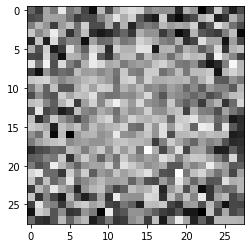

In [18]:
import matplotlib.pyplot as plt
plt.imshow(img[0], cmap='gray')

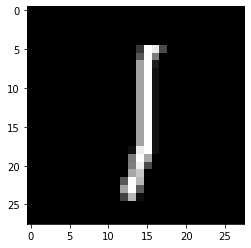

In [19]:
plt.imshow(image.detach().cpu().reshape(BATCHSIZE, 28, 28)[0], cmap='gray')